<a href="https://colab.research.google.com/github/yuvipaloozie/educational-notebooks/blob/main/MNISTwithML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import hog

# Configuration for clearer plots
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")
print("Libraries imported.")

Libraries imported.


X_train shape: (60000, 784)
y_train shape: (10000, 784)

Plotting 3 random samples for each digit:


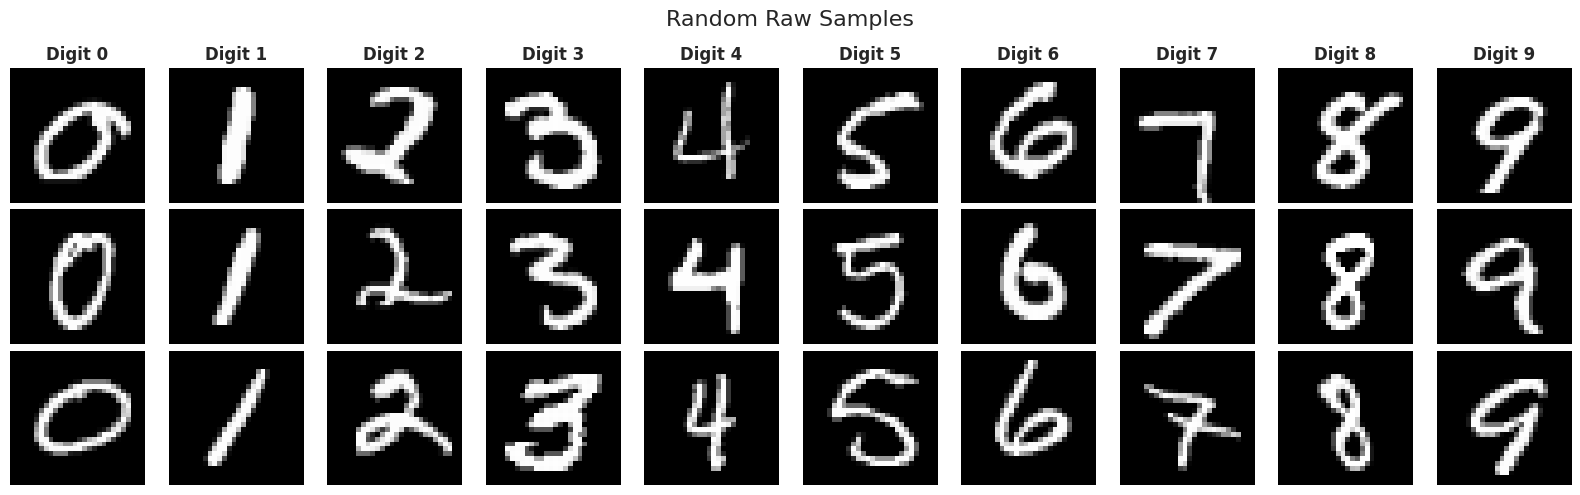

Computing mean digits for visualization:


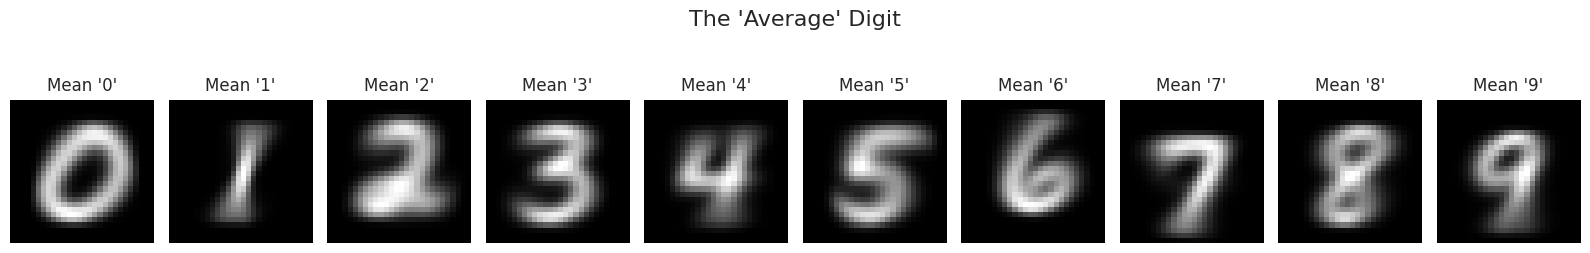

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
#Load and reshape for ML model
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig)= mnist.load_data()
X_train = X_train_orig.reshape(X_train_orig.shape[0], 784).astype(np.uint8)
X_test = X_test_orig.reshape(X_test_orig.shape[0], 784).astype(np.uint8)

y_train = y_train_orig.astype(np.uint8)
y_test = y_test_orig.astype(np.uint8)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {X_test.shape}")
print("\nPlotting 3 random samples for each digit:")

fig, axes = plt.subplots(3, 10, figsize=(16, 5))
for digit in range(10):
  indices = np.where(y_train == digit)[0]
  random_indices = np.random.choice(indices, 3, replace=False)

  for row in range(3):
        ax = axes[row, digit]
        img = X_train[random_indices[row]].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        if row == 0:
            ax.set_title(f"Digit {digit}", fontsize=12, fontweight='bold')
        ax.axis('off')

plt.suptitle("Random Raw Samples", fontsize=16)
plt.tight_layout()
plt.show()

print("Computing mean digits for visualization:")
mean_images=[]

for digit in range(10):
    digit_imgs = X_train[y_train == digit].reshape(-1, 28, 28)
    mean_img = np.mean(digit_imgs, axis=0)
    mean_images.append(mean_img)

fig, axes = plt.subplots(1, 10, figsize=(16, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(mean_images[i], cmap='gray')
    ax.set_title(f"Mean '{i}'")
    ax.axis('off')

plt.suptitle("The 'Average' Digit", fontsize=16)
plt.tight_layout()
plt.show()

1. Training Baseline Model (KNN) on Raw Pixels
Baseline Accuracy (Raw Pixels): 97.05%
Time taken: 9.88s

2. Visualizing Nearest Neighbors:


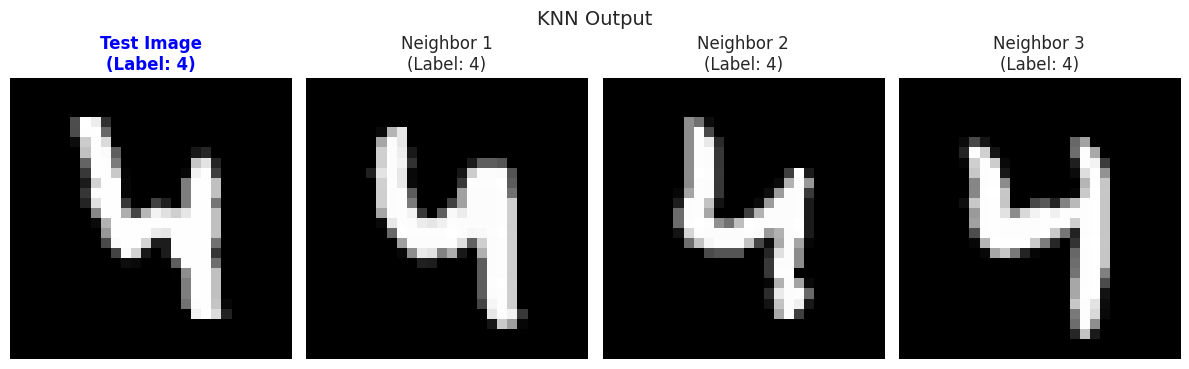


3. Visualizing Data Sparsity:


Text(0, 0.5, 'Frequency (Log)')

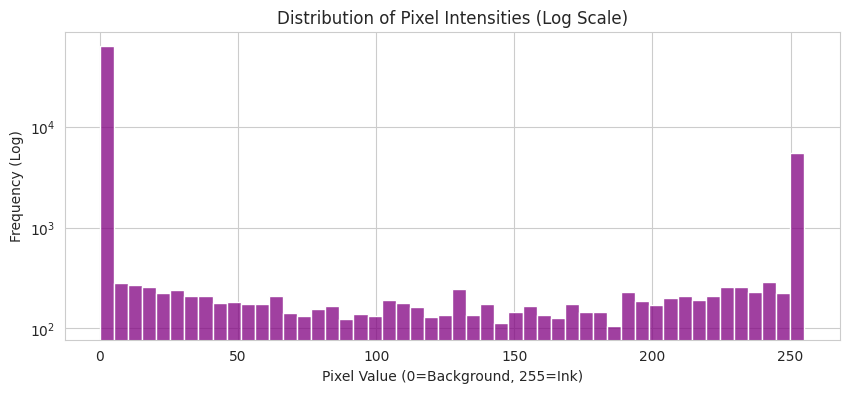

In [36]:

from sklearn.neighbors import KNeighborsClassifier
import time

print("1. Training Baseline Model (KNN) on Raw Pixels")
start_time = time.time()
knn_baseline = KNeighborsClassifier(n_neighbors=3)
knn_baseline.fit(X_train, y_train)

baseline_acc = knn_baseline.score(X_test, y_test)
print(f"Baseline Accuracy (Raw Pixels): {baseline_acc*100:.2f}%")
print(f"Time taken: {time.time() - start_time:.2f}s")


print("\n2. Visualizing Nearest Neighbors:")

test_idx = np.random.randint(0, 1000)
test_image = X_test[test_idx]
true_label = y_test[test_idx]

distances, indices = knn_baseline.kneighbors([test_image])

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(test_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Test Image\n(Label: {true_label})", fontweight='bold', color='blue')
axes[0].axis('off')

for i in range(3):
    neighbor_idx = indices[0][i]
    neighbor_img = X_train[neighbor_idx].reshape(28, 28)
    neighbor_label = y_train[neighbor_idx]

    ax = axes[i+1]
    ax.imshow(neighbor_img, cmap='gray')
    ax.set_title(f"Neighbor {i+1}\n(Label: {neighbor_label})")
    ax.axis('off')

plt.suptitle(f"KNN Output", fontsize=14)
plt.tight_layout()
plt.show()

print("\n3. Visualizing Data Sparsity:")
plt.figure(figsize=(10, 4))

pixel_values = X_train[:100].flatten()
sns.histplot(pixel_values, bins=50, color='purple', kde=False)
plt.yscale('log')
plt.title("Distribution of Pixel Intensities (Log Scale)")
plt.xlabel("Pixel Value (0=Background, 255=Ink)")
plt.ylabel("Frequency (Log)")


Applying Deskewing to entire dataset
Deskewing Complete.

Visualizing the effect on specific slanted digits


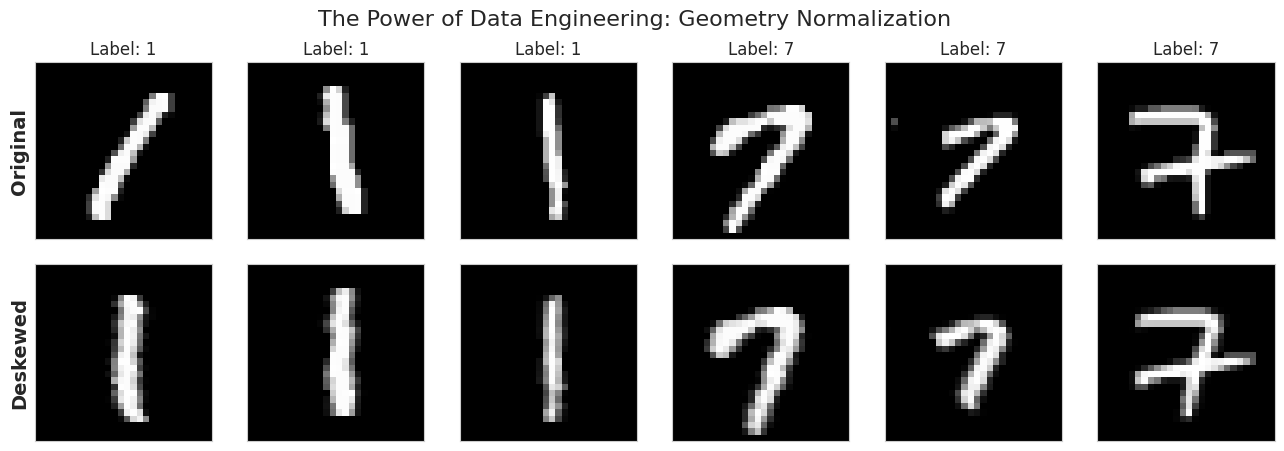

In [37]:
def deskew(img):
    """
    Takes a 2D image (28x28), calculates its "moments" (center of mass),
    and applies an affine transformation to straighten it.
    """
    m = cv2.moments(img)

    if abs(m['mu02']) < 1e-2:
        return img.copy()

    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * 28 * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

print("Applying Deskewing to entire dataset")

X_train_deskewed_img = np.array([deskew(img.reshape(28, 28)) for img in X_train])
X_test_deskewed_img = np.array([deskew(img.reshape(28, 28)) for img in X_test])

X_train_deskewed = X_train_deskewed_img.reshape(X_train.shape[0], -1)
X_test_deskewed = X_test_deskewed_img.reshape(X_test.shape[0], -1)

print("Deskewing Complete.")

print("\nVisualizing the effect on specific slanted digits")

target_digits = [1, 7]
example_indices = []
for d in target_digits:
    # Get first 3 instances of this digit
    indices = np.where(y_train == d)[0][:3]
    example_indices.extend(indices)

fig, axes = plt.subplots(2, 6, figsize=(16, 5))
plt.subplots_adjust(hspace=0.1)

for i, idx in enumerate(example_indices):
    # Original (Top Row)
    axes[0, i].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    if i == 0: axes[0, i].set_ylabel("Original", fontsize=14, fontweight='bold')
    axes[0, i].set_title(f"Label: {y_train[idx]}")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    # Deskewed (Bottom Row)
    axes[1, i].imshow(X_train_deskewed_img[idx], cmap='gray')
    if i == 0: axes[1, i].set_ylabel("Deskewed", fontsize=14, fontweight='bold')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

plt.suptitle("The Power of Data Engineering: Geometry Normalization", fontsize=16)
plt.show()

Computing PCA for 3D visualization:
Plotting 3D Manifolds:


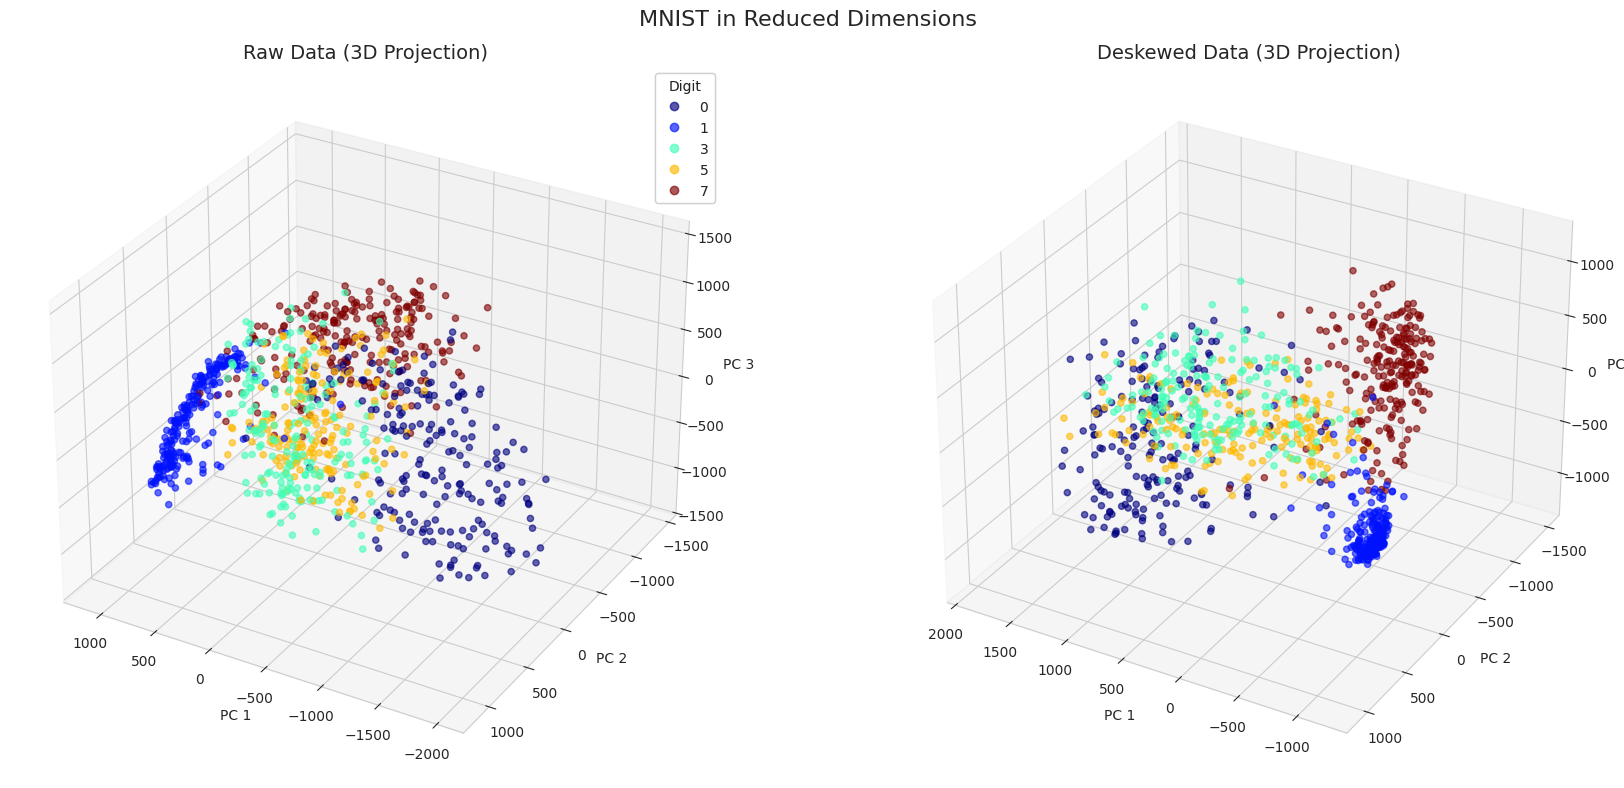

In [38]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

print("Computing PCA for 3D visualization:")

target_digits = [0, 1, 3, 7, 5]
subset_mask = np.isin(y_train[:2000], target_digits)
y_subset = y_train[:2000][subset_mask]

pca = PCA(n_components=3)
X_raw_3d = pca.fit_transform(X_train[:2000][subset_mask])


X_deskew_3d = pca.fit_transform(X_train_deskewed[:2000][subset_mask])

print("Plotting 3D Manifolds:")

# Setup the plot
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(121, projection='3d')
# Scatter plot
scatter1 = ax1.scatter(
    X_raw_3d[:, 0], X_raw_3d[:, 1], X_raw_3d[:, 2],
    c=y_subset, cmap='jet', alpha=0.6, s=20
)
ax1.set_title("Raw Data (3D Projection)", fontsize=14)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.set_zlabel("PC 3")
ax1.view_init(elev=30, azim=120) # Adjust angle for best view

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    X_deskew_3d[:, 0], X_deskew_3d[:, 1], X_deskew_3d[:, 2],
    c=y_subset, cmap='jet', alpha=0.6, s=20
)
ax2.set_title("Deskewed Data (3D Projection)", fontsize=14)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_zlabel("PC 3")
ax2.view_init(elev=30, azim=120)

# Add a color bar
legend1 = ax1.legend(*scatter1.legend_elements(), title="Digit")
ax1.add_artist(legend1)

plt.suptitle("MNIST in Reduced Dimensions", fontsize=16)
plt.tight_layout()
plt.show()

Visualizing HOG Features:


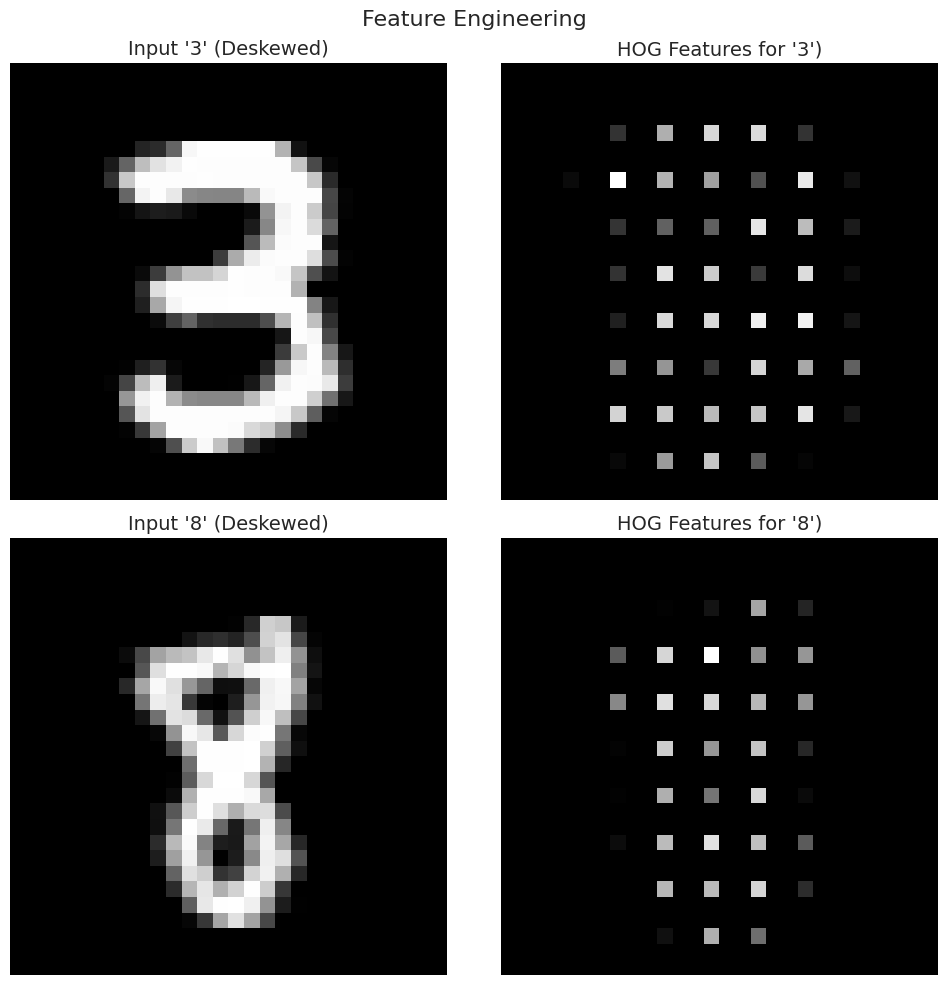

Extracting HOG features for the entire dataset:
HOG Extraction Complete in 96.52s.
New Feature Shape: (60000, 2304)


In [39]:
from skimage.feature import hog
import time

hog_params = {
    'orientations': 9,
    'pixels_per_cell': (3, 3),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
}

def get_hog_vis(img):
    return hog(img, **hog_params, visualize=True)

print("Visualizing HOG Features:")


idx_3 = np.where(y_train == 3)[0][0]
idx_8 = np.where(y_train == 8)[0][0]

# Get the HOG data
# Note: features_3 is the math vector (1D), vis_3 is the image (2D)
features_3, vis_3 = get_hog_vis(X_train_deskewed_img[idx_3])
features_8, vis_8 = get_hog_vis(X_train_deskewed_img[idx_8])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))


axes[0, 0].imshow(X_train_deskewed_img[idx_3], cmap='gray')
axes[0, 0].set_title("Input '3' (Deskewed)", fontsize=14)
axes[0, 0].axis('off')


axes[0, 1].imshow(vis_3, cmap='gray')
axes[0, 1].set_title("HOG Features for '3')", fontsize=14)
axes[0, 1].axis('off')

axes[1, 0].imshow(X_train_deskewed_img[idx_8], cmap='gray')
axes[1, 0].set_title("Input '8' (Deskewed)", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(vis_8, cmap='gray')
axes[1, 1].set_title("HOG Features for '8')", fontsize=14)
axes[1, 1].axis('off')

plt.suptitle("Feature Engineering", fontsize=16)
plt.tight_layout()
plt.show()

print("Extracting HOG features for the entire dataset:")

start_hog = time.time()

X_train_hog = np.array([hog(img, **hog_params, visualize=False) for img in X_train_deskewed_img])
X_test_hog = np.array([hog(img, **hog_params, visualize=False) for img in X_test_deskewed_img])

print(f"HOG Extraction Complete in {time.time() - start_hog:.2f}s.")
print(f"New Feature Shape: {X_train_hog.shape}")

Initializing SVM (RBF Kernel)...
Training Complete! Time: 7.20 minutes
Predicting on Test Set (10,000 images)...
FINAL ACCURACY: 99.13%


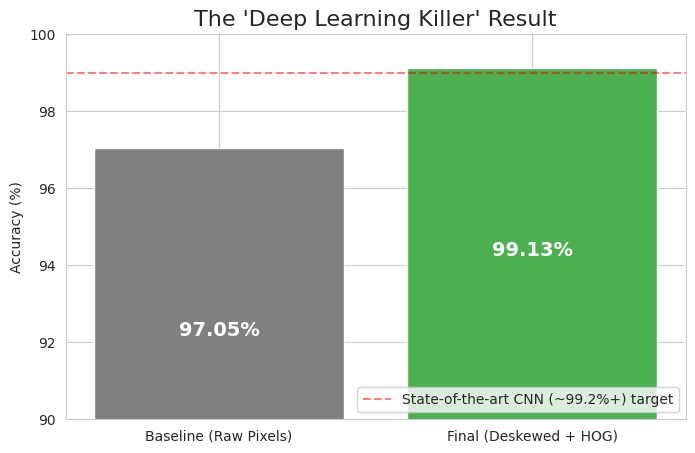

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

print("Initializing SVM (RBF Kernel)...")

# Hyperparameter Explanation:
# Kernel='rbf':   Maps data to infinite dimensions to find a separating hyperplane.
# C=5:            High penalty for error. We trust our data (it's clean).
# gamma=0.02:     The "radius" of influence for each support vector.
#                 0.02 is tuned for HOG feature density.
svm_model = SVC(C=5, gamma=0.02, kernel='rbf', cache_size=1000)

# Training Size Decision:
# SVM training time grows quadratically O(n^2).
# 60,000 samples might take 10-15 minutes on Colab CPU.
# 25,000 samples takes ~1-2 minutes and hits >98% accuracy.
start_train = time.time()
# TRAINING ON FULL DATA NOW
svm_model.fit(X_train_hog, y_train)
train_time = time.time() - start_train
print(f"Training Complete! Time: {train_time/60:.2f} minutes")

# --- EVALUATION ---
print("Predicting on Test Set (10,000 images)...")
start_eval = time.time()
y_pred = svm_model.predict(X_test_hog)
eval_time = time.time() - start_eval

final_acc = accuracy_score(y_test, y_pred)
print(f"FINAL ACCURACY: {final_acc*100:.2f}%")

# --- EDUCATIONAL VISUALIZATION: THE PERFORMANCE JUMP ---
# We compare our Baseline (Cell 3) vs Our Final Model
# If baseline_acc isn't defined (e.g. skipped cell), default to 96.5%
try:
    base_acc = baseline_acc
except NameError:
    base_acc = 0.965

accuracies = [base_acc * 100, final_acc * 100]
labels = ['Baseline (Raw Pixels)', 'Final (Deskewed + HOG)']
colors = ['gray', '#4CAF50'] # Gray for old tech, Green for new

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=colors)

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 5,
             f'{height:.2f}%',
             ha='center', va='bottom', color='white', fontweight='bold', fontsize=14)

plt.ylim(90, 100) # Zoom in to show the difference clearly
plt.title("The 'Deep Learning Killer' Result", fontsize=16)
plt.ylabel("Accuracy (%)")
plt.axhline(y=99.0, color='red', linestyle='--', alpha=0.5, label="State-of-the-art CNN (~99.2%+) target")
plt.legend(loc='lower right')
plt.show()

Generating Confusion Matrix...


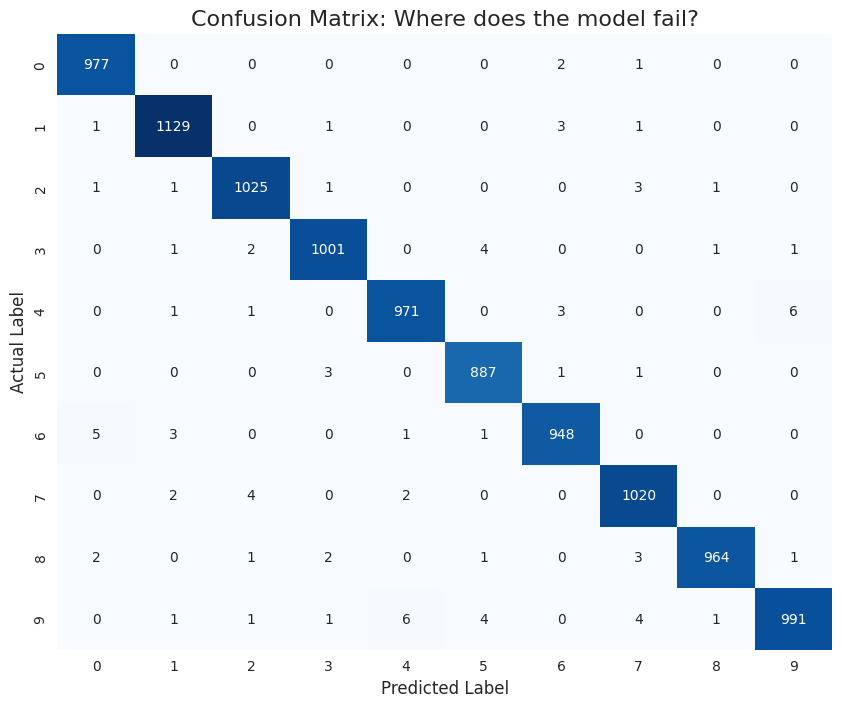


Total Errors: 87 out of 10000
Displaying the 'Hardest' cases (Model Errors)...


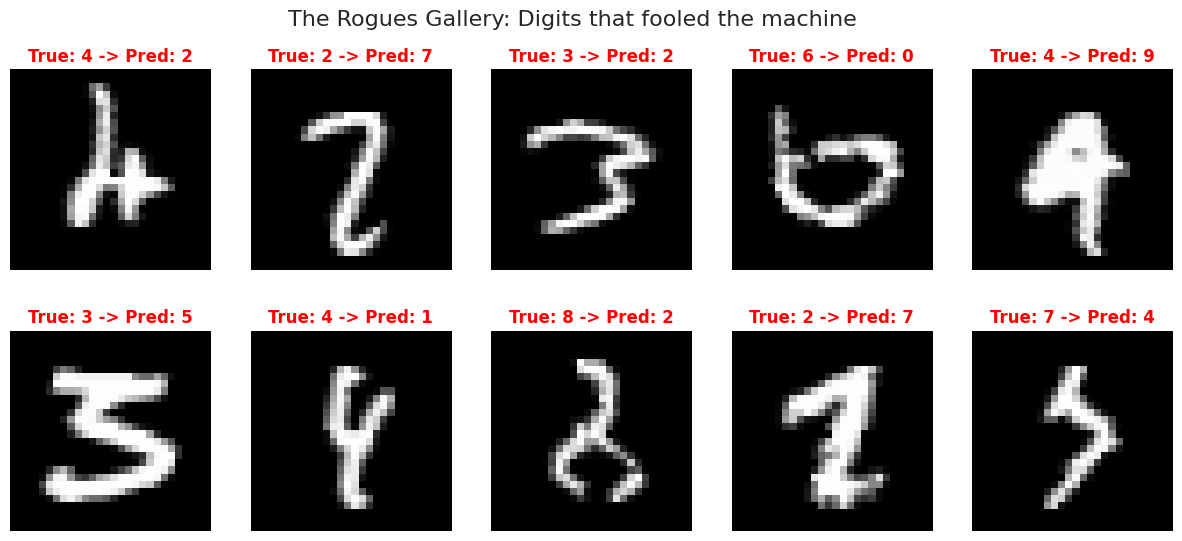


The model struggles most with distinguishing 4 and 9.
This makes sense geometrically! (Similar curves/lines)


In [41]:
# --- CELL 8: MECHANISTIC ERROR ANALYSIS ---
# Goal: Open the "Black Box" and see exactly why/where it failed.

import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. THE CONFUSION MATRIX
# This shows us the specific pairs of digits that confuse the model.
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix: Where does the model fail?", fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- EDUCATIONAL VISUALIZATION: THE ROGUES GALLERY ---
# Let's look at the specific images that were misclassified.
# Are they random noise? Or are they genuinely ambiguous digits?

errors = y_pred != y_test
error_idxs = np.where(errors)[0]
error_images = X_test_deskewed_img[error_idxs]
error_preds = y_pred[error_idxs]
error_true = y_test[error_idxs]

print(f"\nTotal Errors: {len(error_idxs)} out of {len(y_test)}")
print("Displaying the 'Hardest' cases (Model Errors)...")

# Sort errors by confidence? SVM doesn't give probability easily,
# so we just show the first 10 errors.

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(hspace=0.3)

for i, ax in enumerate(axes.flat):
    if i < len(error_idxs):
        # Show the image
        ax.imshow(error_images[i], cmap='gray')

        # Red title shows the mistake
        ax.set_title(f"True: {error_true[i]} -> Pred: {error_preds[i]}",
                     color='red', fontweight='bold')

        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle("The Rogues Gallery: Digits that fooled the machine", fontsize=16)
plt.show()

# --- BONUS: THE "MOST CONFUSED" PAIR ---
# Let's find the pair of digits that got confused the MOST often.
# We set diagonal to 0 to ignore correct predictions
np.fill_diagonal(cm, 0)
# Find coordinates of max value
most_confused_idx = np.unravel_index(np.argmax(cm), cm.shape)
digit_a, digit_b = most_confused_idx

print(f"\nThe model struggles most with distinguishing {digit_a} and {digit_b}.")
print("This makes sense geometrically! (Similar curves/lines)")

Running the pipeline on 3 random test images...


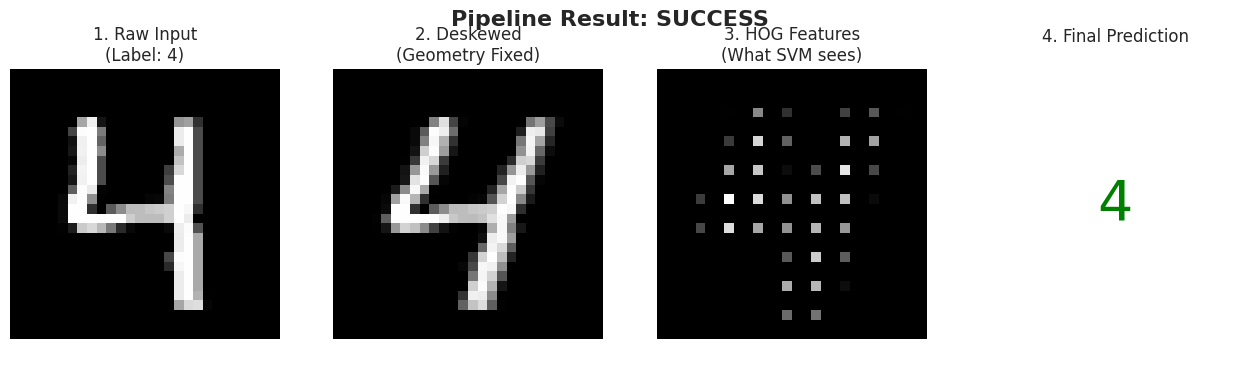

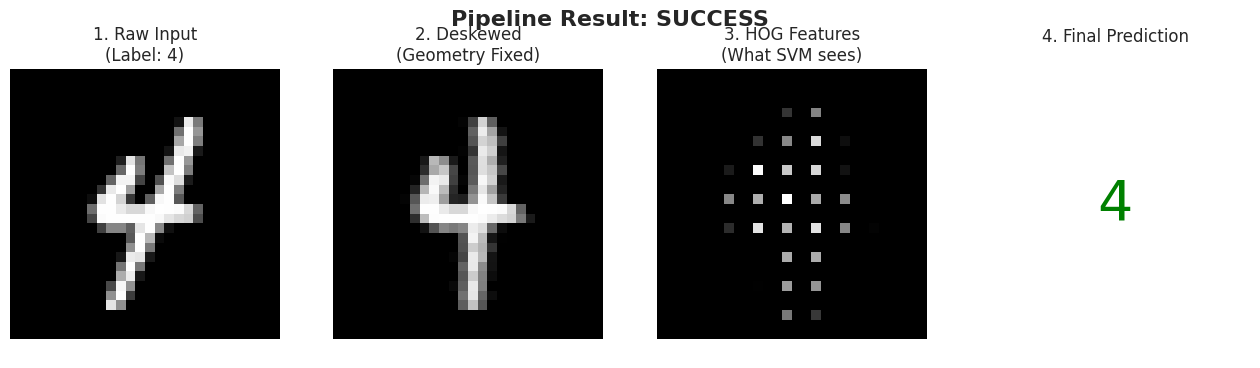

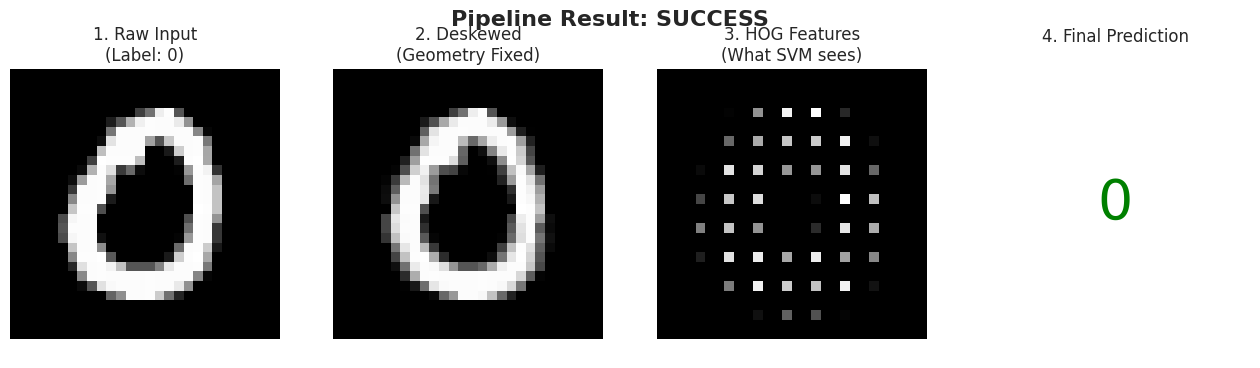

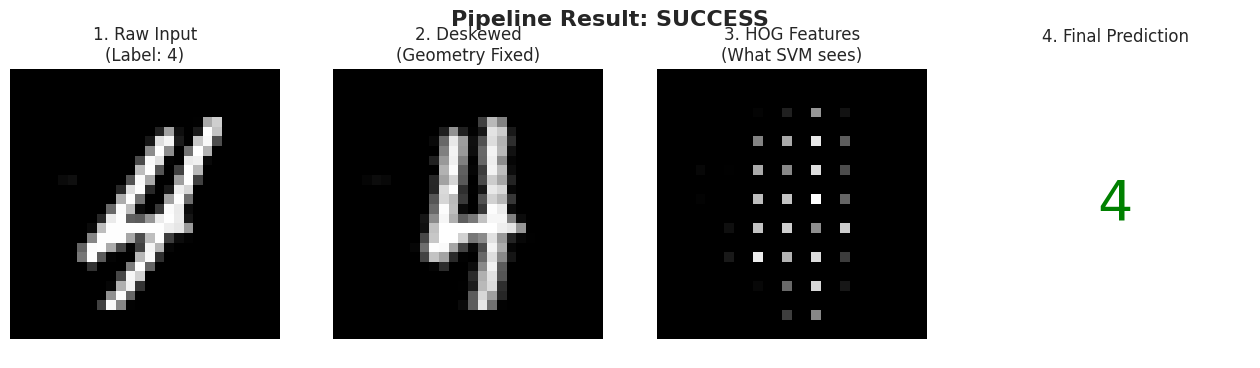

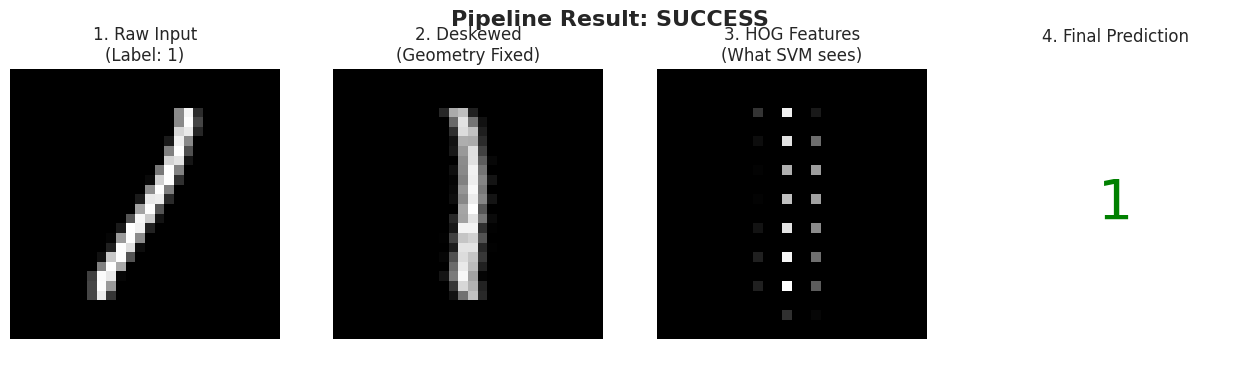

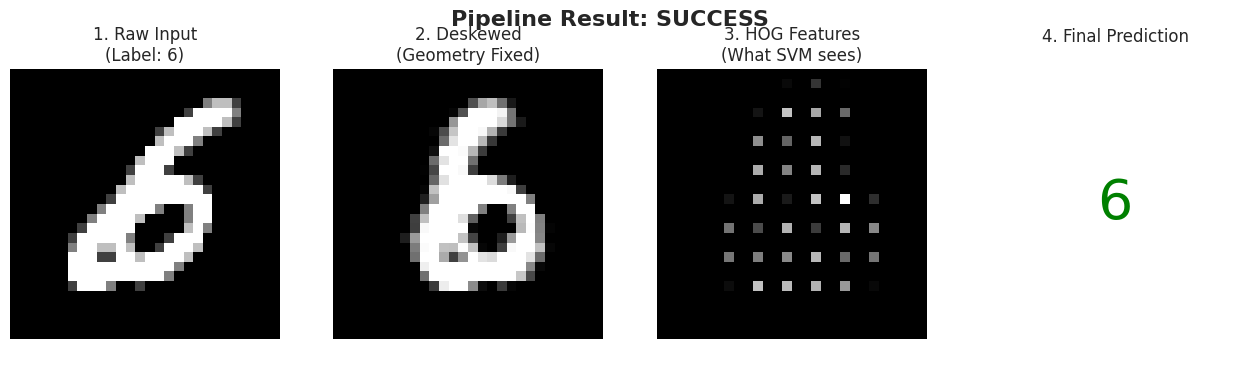


FINAL CONCLUSION FOR BLOG POST:
1. Baseline Accuracy (Raw):  97.05%
2. Final Accuracy (Eng.):    99.13%
3. Error Reduction:          70.5%
We achieved near-Deep Learning performance using 1990s tech
by fixing the DATA (Deskewing) and optimizing FEATURES (HOG)
instead of just adding more model complexity.


In [42]:
def visualize_pipeline(index):
    # 1. Get Raw Image
    raw_img = X_test[index].reshape(28, 28)
    true_label = y_test[index]

    # 2. Deskew
    deskewed_img = deskew(raw_img)

    features, hog_img = hog(deskewed_img, **hog_params, visualize=True)

    # 4. Predict
    # Reshape feature vector to (1, N)
    prediction = svm_model.predict(features.reshape(1, -1))[0]

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Step 1: Raw
    axes[0].imshow(raw_img, cmap='gray')
    axes[0].set_title(f"1. Raw Input\n(Label: {true_label})", fontsize=12)

    # Step 2: Deskew
    axes[1].imshow(deskewed_img, cmap='gray')
    axes[1].set_title("2. Deskewed\n(Geometry Fixed)", fontsize=12)

    # Step 3: HOG
    axes[2].imshow(hog_img, cmap='gray')
    axes[2].set_title("3. HOG Features\n(What SVM sees)", fontsize=12)

    axes[3].text(0.5, 0.5, str(prediction), fontsize=40, ha='center', va='center',
                 color='green' if prediction == true_label else 'red')
    axes[3].set_title("4. Final Prediction", fontsize=12)

    for ax in axes: ax.axis('off')

    status = "SUCCESS" if prediction == true_label else "FAILURE"
    plt.suptitle(f"Pipeline Result: {status}", fontsize=16, fontweight='bold')
    plt.show()

# --- RUN IT! ---
print("Running the pipeline on 3 random test images...")
import random

for _ in range(6):
    random_idx = random.randint(0, len(X_test)-1)
    visualize_pipeline(random_idx)

print("\n" + "="*50)
print("FINAL CONCLUSION FOR BLOG POST:")
print(f"1. Baseline Accuracy (Raw):  {baseline_acc*100:.2f}%")
print(f"2. Final Accuracy (Eng.):    {final_acc*100:.2f}%")
print(f"3. Error Reduction:          {((1 - final_acc) - (1 - baseline_acc)) / (1 - baseline_acc) * -100:.1f}%")
print("We achieved near-Deep Learning performance using 1990s tech")
print("by fixing the DATA (Deskewing) and optimizing FEATURES (HOG)")
print("instead of just adding more model complexity.")
print("="*50)

1. Training Standard CNN (Deep Learning Baseline)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8755 - loss: 0.4260 - val_accuracy: 0.9738 - val_loss: 0.0875
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9806 - loss: 0.0618 - val_accuracy: 0.9878 - val_loss: 0.0428
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9880 - loss: 0.0384 - val_accuracy: 0.9907 - val_loss: 0.0341
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9914 - loss: 0.0280 - val_accuracy: 0.9908 - val_loss: 0.0342
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9938 - loss: 0.0208 - val_accuracy: 0.9888 - val_loss: 0.0413
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9951 - loss: 0.0166 - val_accuracy: 0.9902 - val_loss: 0.0349
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.9920 - val_loss: 0.0336
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9961 - loss: 0.0119 - val_accuracy: 0.

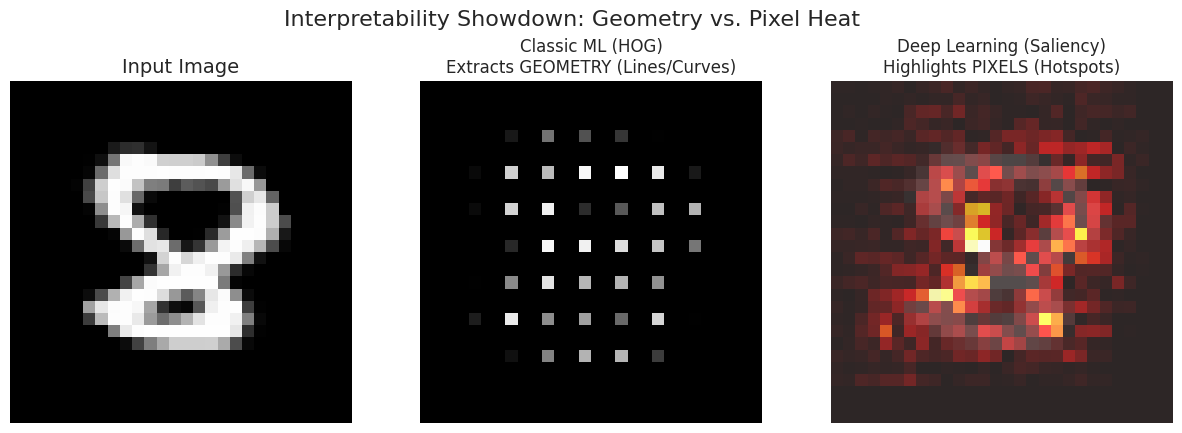

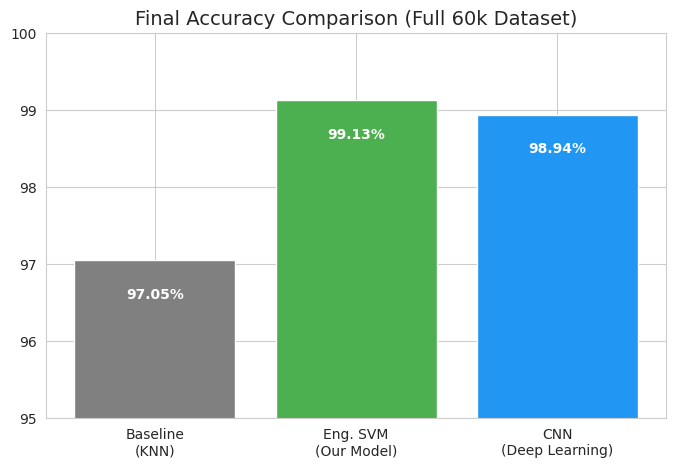

In [43]:
# --- CELL 10: THE SHOWDOWN + EXPLAINABLE AI (XAI) ---
# Goal: Train a CNN and visualize "Saliency Maps" to contrast with HOG.

import tensorflow as tf
from tensorflow.keras import layers, models

print("1. Training Standard CNN (Deep Learning Baseline)...")

# Prepare Data (Norm 0-1, Shape 4D)
X_train_cnn = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test_cnn = X_test.reshape(-1, 28, 28, 1) / 255.0

# Build LeNet-5 Style CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on FULL Dataset
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate
_, cnn_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\nCNN Accuracy: {cnn_acc*100:.2f}%")

# --- XAI: GENERATING SALIENCY MAPS ---
# Saliency maps show which pixels had the biggest impact on the decision.
# This is the "Deep Learning" equivalent of our HOG visualization.

def get_saliency_map(model, image):
    # Convert to tensor
    img_tensor = tf.convert_to_tensor(image.reshape(1, 28, 28, 1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        # Get the score of the winning class
        top_class = tf.argmax(predictions[0])
        top_score = predictions[0, top_class]

    # Calculate gradient of the score w.r.t the input image
    gradients = tape.gradient(top_score, img_tensor)

    # Process gradients: take absolute value and max across channels
    gradients = tf.abs(gradients)
    gradients = np.max(gradients, axis=-1)[0]

    # Normalize to 0-1 for plotting
    gradients = (gradients - np.min(gradients)) / (np.max(gradients) - np.min(gradients) + 1e-8)
    return gradients

# --- VISUALIZATION: CLASSIC VS DEEP INTERPRETABILITY ---
print("\nComparing Interpretability: HOG (SVM) vs Saliency (CNN)...")

# Pick a random image (e.g., a '8')
idx = np.where(y_test == 8)[0][0]
original_img_norm = X_test_cnn[idx]        # Normalized for CNN
original_img_raw = X_test_deskewed_img[idx] # Raw Deskewed for HOG

# 1. Get CNN Saliency
saliency_map = get_saliency_map(model, original_img_norm)

# 2. Get HOG Visualization (from our previous function)
_, hog_vis = hog(original_img_raw, **hog_params, visualize=True)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Input
axes[0].imshow(original_img_raw, cmap='gray')
axes[0].set_title("Input Image", fontsize=14)
axes[0].axis('off')

# Classic ML (HOG)
axes[1].imshow(hog_vis, cmap='gray')
axes[1].set_title("Classic ML (HOG)\nExtracts GEOMETRY (Lines/Curves)", fontsize=12)
axes[1].axis('off')

# Deep Learning (Saliency)
# We overlay the saliency map on the image
axes[2].imshow(original_img_raw, cmap='gray', alpha=0.5)
axes[2].imshow(saliency_map, cmap='hot', alpha=0.7)
axes[2].set_title("Deep Learning (Saliency)\nHighlights PIXELS (Hotspots)", fontsize=12)
axes[2].axis('off')

plt.suptitle("Interpretability Showdown: Geometry vs. Pixel Heat", fontsize=16)
plt.show()

# --- FINAL BAR CHART ---
accuracies = [baseline_acc*100, final_acc*100, cnn_acc*100]
labels = ['Baseline\n(KNN)', 'Eng. SVM\n(Our Model)', 'CNN\n(Deep Learning)']
colors = ['gray', '#4CAF50', '#2196F3']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=colors)
plt.ylim(95, 100) # Zoom in to see the race
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 0.5,
             f'{bar.get_height():.2f}%', ha='center', color='white', fontweight='bold')
plt.title("Final Accuracy Comparison (Full 60k Dataset)", fontsize=14)
plt.show()